### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 7     

In [16]:
from util.VisualizeDataset import VisualizeDataset
from Chapter7.PrepareDatasetForLearning import PrepareDatasetForLearning
from Chapter7.LearningAlgorithms import ClassificationAlgorithms
from Chapter7.LearningAlgorithms import RegressionAlgorithms
from Chapter7.Evaluation import ClassificationEvaluation
from Chapter7.Evaluation import RegressionEvaluation
from Chapter7.FeatureSelection import FeatureSelectionClassification
from Chapter7.FeatureSelection import FeatureSelectionRegression
import copy
import pandas as pd
from util import util
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import os

In [2]:
DataViz = VisualizeDataset()

# Read the result from the previous chapter, and make sure the index is of the type datetime.

dataset_path = 'intermediate_datafiles/'
export_tree_path = 'Example_graphs/Chapter7/'

try:
    dataset = pd.read_csv(dataset_path + 'chapter5_result.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

if not os.path.exists(export_tree_path):
    os.makedirs(export_tree_path)

dataset.index = dataset.index.to_datetime()

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


In [3]:
del dataset['participant']
del dataset['category']
del dataset['set']

In [4]:
# Let us consider our first task, namely the prediction of the label. We consider this as a non-temporal task.

# We create a single column with the categorical attribute representing our class. Furthermore, we use 70% of our data
# for training and the remaining 30% as an independent test set. We select the sets based on stratified sampling. We remove
# cases where we do not know the label.

prepare = PrepareDatasetForLearning()

train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset, ['label'], 'like', 0.7, filter=True, temporal=False)
#train_X, test_X, train_y, test_y = prepare.split_single_dataset_classification(dataset, ['label'], 'like', 0.01, filter=True, temporal=False)

print 'Training set length is: ', len(train_X.index)
print 'Test set length is: ', len(test_X.index)

Training set length is:  4236
Test set length is:  1816


In [5]:
# Select subsets of the features that we will consider:

basic_features = ['acc_x','acc_y','acc_z', 'gyr_x','gyr_y','gyr_z', 'acc_r', 'gyr_r']
pca_features = ['pca_1','pca_2','pca_3']
time_features = [name for name in dataset.columns if '_temp_' in name]
freq_features = [name for name in dataset.columns if (('_freq' in name) or ('_pse' in name))]
print '#basic features: ', len(basic_features)
print '#PCA features: ', len(pca_features)
print '#time features: ', len(time_features)
print '#frequency features: ', len(freq_features)
cluster_features = ['cluster']
print '#cluster features: ', len(cluster_features)
features_after_chapter_3 = list(set().union(basic_features, pca_features))
features_after_chapter_4 = list(set().union(basic_features, pca_features, time_features, freq_features))
features_after_chapter_5 = list(set().union(basic_features, pca_features, time_features, freq_features, cluster_features))

#basic features:  8
#PCA features:  3
#time features:  16
#frequency features:  58
#cluster features:  1


In [ ]:
# First, let us consider the performance over a selection of features:

fs = FeatureSelectionClassification()

features, ordered_features, ordered_scores = fs.forward_selection(86, train_X[features_after_chapter_5], train_y)
print ordered_scores
print ordered_features

plot.plot(range(1, 87), ordered_scores)
plot.xlabel('number of features')
plot.ylabel('accuracy')
plot.show()

In [ ]:
ordered_features[:20]

In [ ]:
selected_features = ordered_features[:10]

In [6]:
selected_features = ['gyr_r_freq_0.0_Hz_ws_50',
                     'acc_y_temp_mean_ws_5',
                     'acc_x_temp_mean_ws_5',
                     'acc_y_temp_std_ws_5',
                     'acc_x_temp_std_ws_5',
                     'acc_z_temp_std_ws_5',
                     'gyr_z',
                     'gyr_r_freq_0.4_Hz_ws_50',
                     'gyr_y_temp_mean_ws_5',
                     'acc_r_freq_1.0_Hz_ws_50']

In [7]:
learner = ClassificationAlgorithms()
eval = ClassificationEvaluation()

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


[0.99922096317280451, 0.99977573182247392, 0.99975212464589236, 0.99881964117091593, 0.98227101038715769, 0.85349386213408884]
[0.94741189427312789, 0.94906387665198244, 0.94523678414096945, 0.93631607929515415, 0.9135187224669602, 0.80988436123348018]


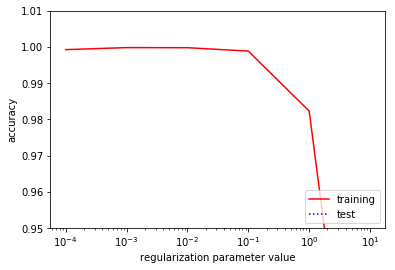

In [8]:
reg_parameters = [0.0001, 0.001, 0.01, 0.1, 1, 10]
performance_training = []
performance_test = []

repeats = 20

for reg_param in reg_parameters:
    performance_tr = 0
    performance_te = 0
    for i in range(0, repeats):
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.feedforward_neural_network(train_X, train_y,
                                                                                                            test_X, hidden_layer_sizes=(250, ), alpha=reg_param, max_iter=500,
                                                                                                            gridsearch=False)
        performance_tr += eval.accuracy(train_y, class_train_y)
        performance_te += eval.accuracy(test_y, class_test_y)
    performance_training.append(performance_tr/repeats)
    performance_test.append(performance_te/repeats)

plot.hold(True)
plot.semilogx(reg_parameters, performance_training, 'r-')
plot.semilogx(reg_parameters, performance_test, 'b:')
print performance_training
print performance_test
plot.xlabel('regularization parameter value')
plot.ylabel('accuracy')
plot.ylim([0.95, 1.01])
plot.legend(['training', 'test'], loc=4)
plot.hold(False)

plot.show()

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  del sys.path[0]
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


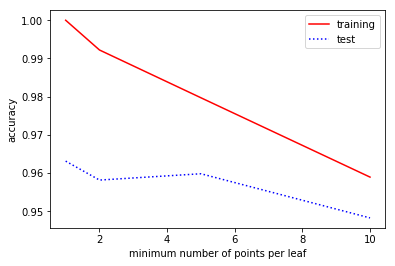

In [9]:
# Second, let us consider the influence of certain parameter settings (very related to the regulariztion) and study the impact on performance.

leaf_settings = [1,2,5,10]
performance_training = []
performance_test = []

for no_points_leaf in leaf_settings:
    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(train_X[selected_features], train_y, test_X[selected_features], min_samples_leaf=no_points_leaf,
                                                                                               gridsearch=False, print_model_details=False)
    performance_training.append(eval.accuracy(train_y, class_train_y))
    performance_test.append(eval.accuracy(test_y, class_test_y))

plot.hold(True)
plot.plot(leaf_settings, performance_training, 'r-')
plot.plot(leaf_settings, performance_test, 'b:')
plot.xlabel('minimum number of points per leaf')
plot.ylabel('accuracy')
plot.legend(['training', 'test'], loc=1)
plot.hold(False)

plot.show()

In [10]:
# So yes, it is important :) Therefore we perform grid searches over the most important parameters, and do so by means
# of cross validation upon the training set.

possible_feature_sets = [basic_features, features_after_chapter_3, features_after_chapter_4, features_after_chapter_5]
feature_names = ['initial set', 'Chapter 3', 'Chapter 4', 'Chapter 5']
repeats = 5

scores_over_all_algs = []

for i in range(0, len(possible_feature_sets)):
    selected_train_X = train_X[possible_feature_sets[i]]
    selected_test_X = test_X[possible_feature_sets[i]]

    # First we run our non deterministic classifiers a number of times to average their score.

    performance_tr_nn = 0
    performance_tr_rf = 0
    performance_tr_svm = 0
    performance_te_nn = 0
    performance_te_rf = 0
    performance_te_svm = 0

    for repeat in range(0, repeats):
        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.feedforward_neural_network(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_nn += eval.accuracy(train_y, class_train_y)
        performance_te_nn += eval.accuracy(test_y, class_test_y)

        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_rf += eval.accuracy(train_y, class_train_y)
        performance_te_rf += eval.accuracy(test_y, class_test_y)

        class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.support_vector_machine_with_kernel(selected_train_X, train_y, selected_test_X, gridsearch=True)
        performance_tr_svm += eval.accuracy(train_y, class_train_y)
        performance_te_svm += eval.accuracy(test_y, class_test_y)


    overall_performance_tr_nn = performance_tr_nn/repeats
    overall_performance_te_nn = performance_te_nn/repeats
    overall_performance_tr_rf = performance_tr_rf/repeats
    overall_performance_te_rf = performance_te_rf/repeats
    overall_performance_tr_svm = performance_tr_svm/repeats
    overall_performance_te_svm = performance_te_svm/repeats

    # And we run our deterministic classifiers:


    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.k_nearest_neighbor(selected_train_X, train_y, selected_test_X, gridsearch=True)
    performance_tr_knn = eval.accuracy(train_y, class_train_y)
    performance_te_knn = eval.accuracy(test_y, class_test_y)

    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.decision_tree(selected_train_X, train_y, selected_test_X, gridsearch=True)
    performance_tr_dt = eval.accuracy(train_y, class_train_y)
    performance_te_dt = eval.accuracy(test_y, class_test_y)

    class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = learner.naive_bayes(selected_train_X, train_y, selected_test_X)
    performance_tr_nb = eval.accuracy(train_y, class_train_y)
    performance_te_nb = eval.accuracy(test_y, class_test_y)

    scores_with_sd = util.print_table_row_performances(feature_names[i], len(selected_train_X.index), len(selected_test_X.index), [
                                                                                                (overall_performance_tr_nn, overall_performance_te_nn),
                                                                                                (overall_performance_tr_rf, overall_performance_te_rf),
                                                                                                (overall_performance_tr_svm, overall_performance_te_svm),
                                                                                                (performance_tr_knn, performance_te_knn),
                                                                                                (performance_tr_dt, performance_te_dt),
                                                                                                (performance_tr_nb, performance_te_nb)])
    scores_over_all_algs.append(scores_with_sd)

initial set  &  0.8899 \emph{( 0.8803 - 0.8996 )}  &  0.8795 \emph{( 0.8642 - 0.8948 )}  &  0.9949 \emph{( 0.9927 - 0.9971 )}  &  0.9297 \emph{( 0.9177 - 0.9417 )}  &  0.8782 \emph{( 0.8681 - 0.8882 )}  &  0.8464 \emph{( 0.8294 - 0.8633 )}  &  0.6922 \emph{( 0.6780 - 0.7063 )}  &  0.6487 \emph{( 0.6263 - 0.6711 )}  &  0.9297 \emph{( 0.9218 - 0.9375 )}  &  0.8772 \emph{( 0.8618 - 0.8926 )}  &  0.8336 \emph{( 0.8221 - 0.8450 )}  &  0.8348 \emph{( 0.8174 - 0.8522 )} \\\hline
Chapter 3  &  0.8999 \emph{( 0.8906 - 0.9091 )}  &  0.8877 \emph{( 0.8728 - 0.9025 )}  &  0.9939 \emph{( 0.9915 - 0.9963 )}  &  0.9302 \emph{( 0.9182 - 0.9421 )}  &  0.8829 \emph{( 0.8730 - 0.8928 )}  &  0.8519 \emph{( 0.8352 - 0.8685 )}  &  0.6990 \emph{( 0.6849 - 0.7131 )}  &  0.6558 \emph{( 0.6335 - 0.6781 )}  &  0.9337 \emph{( 0.9260 - 0.9413 )}  &  0.8822 \emph{( 0.8670 - 0.8973 )}  &  0.8451 \emph{( 0.8340 - 0.8563 )}  &  0.8469 \emph{( 0.8300 - 0.8638 )} \\\hline
Chapter 4  &  0.9926 \emph{( 0.9900 - 0.9953 )} 

util\VisualizeDataset.py:344: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plot.hold(True)


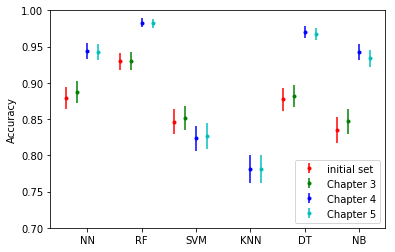

In [11]:
DataViz.plot_performances_classification(['NN', 'RF', 'SVM', 'KNN', 'DT', 'NB'], feature_names, scores_over_all_algs)

In [12]:
# And we study two promising ones in more detail. First let us consider the random forrest which works best with the selected
# features.

class_train_y, class_test_y, class_train_prob_y, class_test_prob_y, model = learner.random_forest(train_X[features_after_chapter_5], train_y, test_X[features_after_chapter_5],
                                                                                           gridsearch=True, print_model_details=True)

{'n_estimators': 100, 'criterion': 'entropy', 'min_samples_leaf': 2}
Feature importance random forest:
acc_y  &  0.105400871948
acc_y_temp_mean_ws_5  &  0.0806123933785
pca_1  &  0.0770333399955
cluster  &  0.0686999314553
acc_z_temp_mean_ws_5  &  0.0679588509079
gyr_r_freq_0.0_Hz_ws_50  &  0.0638089747573
acc_z  &  0.0549557041818
acc_x_temp_mean_ws_5  &  0.0535785400994
gyr_z_temp_std_ws_5  &  0.0532262446393
pca_2  &  0.0491389250962
acc_x  &  0.0400364804304
acc_r_pse  &  0.0281631516704
acc_r_freq_0.0_Hz_ws_50  &  0.0243508190472
gyr_r_temp_mean_ws_5  &  0.0237778278259
acc_x_temp_std_ws_5  &  0.0208308915371
acc_y_temp_std_ws_5  &  0.0204400028052
pca_3  &  0.0194953124886
gyr_r_temp_std_ws_5  &  0.0178478029801
gyr_x_temp_std_ws_5  &  0.0156861977805
acc_r_temp_std_ws_5  &  0.0148212421892
acc_z_temp_std_ws_5  &  0.0086845428333
gyr_y_temp_std_ws_5  &  0.00778302900357
gyr_r_pse  &  0.00700018956745
acc_r_temp_mean_ws_5  &  0.00514493192918
gyr_r  &  0.0039509559153
gyr_z_temp_m

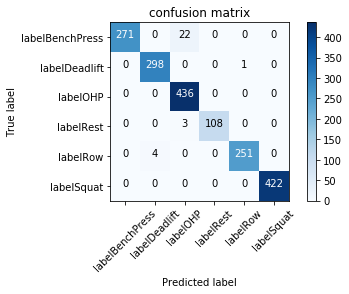

In [13]:
test_cm = eval.confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
DataViz.plot_confusion_matrix(test_cm, class_train_prob_y.columns, normalize=False)

In [17]:
cm = confusion_matrix(test_y, class_test_y, class_train_prob_y.columns)
cr = classification_report(test_y, class_test_y, class_train_prob_y.columns)
accuracy_score(test_y, class_test_y)

0.98348017621145378